# Tree-based models with Random Undersampling

In this notebook tree-based models such as Random Forest, Gradient Boosting and XGBoost are evaluated using Random Undersampling method. After doing hyperparamet tuning on the model with the highest AUC and accuracy, SHAP analysis is used to interpret features usied in classifying patients that were readmitted within 30 days

In [36]:
# !pip install imblearn
# !pip install xgboost
# !pip install shap

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

import shap

In [2]:
# Reading the preprocessed data
pd.set_option('display.max_columns', 200)
df = pd.read_csv('preprocessed.csv')
df.head()

,Unnamed: 0,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,0,5,1,1,41,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
1,1,15,3,9,59,0,18,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

Since preprocessed file included all original columns plus the one-hot features, we can only select the columns that we need for training our model:

In [3]:
df = df.drop(df.columns[0],axis=1)
print(df.shape)
df.head()

(99340, 194)


,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,5,1,1,41,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1
1,15,3,9,59,0,18,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

print(df_train.shape,df_test.shape)
print(df_train.shape,df_test.shape)

(79472, 194) (19868, 194)
(79472, 194) (19868, 194)


In [5]:
#Helper function to calculate the prevalence of the classes
def calculate_prevalence(y):
    print(sum(y)/len(y))

calculate_prevalence(df.iloc[:,-3])
calculate_prevalence(df_train.iloc[:,-3])
calculate_prevalence(df_test.iloc[:,-3])

0.1138916851218039
0.11421632776323737
0.11259311455607006


We can see that proportion of the readmitted class to non-readmitted after partitioning the dataset remains the same and is about 11%.

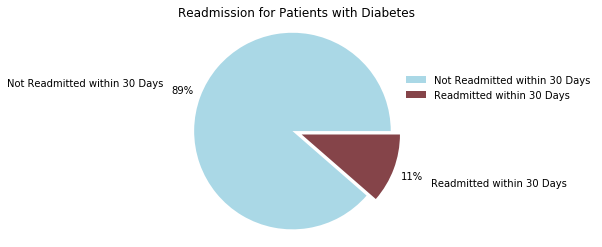

In [6]:
fig, ax = plt.subplots()
color_palette_list = ['#AAD8E6','#854449']
labels = ['Not Readmitted within 30 Days', 
         'Readmitted within 30 Days']
percentages = [88.6, 11.4]
explode=(0.1,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list, autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Readmission for Patients with Diabetes")
ax.legend(frameon=False, bbox_to_anchor=(0.8,0.8))

## Evaluating Models Using Undersampling

There are two main to deal with imbalanced dataset: undersampling and oversampling. In this file we try the undersampling method. Though we don't do this on the whole training set right now since we want to use cross-validation for evaluating the models.

In [7]:
# Shuffling the dataset
df_train = df_train.sample(frac=1,random_state=42).reset_index(drop=True)
df_train.head()

,age,time_in_hospital,number_diagnoses,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,discharge_disposition_id_1,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,discharge_disposition_id_2,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_UNK,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,medical_specialty_Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_486,diag_1_491,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_Others,diag_2_250,diag_2_276,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,diag_3_250,diag_3_272,diag_3_276,diag_3_401,diag_3_403,diag_3_414,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted_<30,readmitted_>30,readmitted_NO
0,85,3,5,28,2,16,3,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1
1,85,7,9,56,0,18,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

Let's seperate the dataframe into labels(y) and features (X): 

In [8]:
# Having the training set as dataframe
all_X_train = df_train.iloc[:,:-3]

# Having the training set as numpy arrays
X_train = df_train.iloc[:,:-3].values
X_test = df_test.iloc[:,:-3].values

y_train = df_train.iloc[:,-3].values
y_test = df_test.iloc[:,-3].values

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
calculate_prevalence(y_train)

(79472, 191) (79472,) (19868, 191) (19868,)
0.11421632776323737


To make sure that different size in the variables is not going to make a problem in any of the models, we should normalize them. One way to do that is to use the standard scaler which removes the mean and scales down to unit variance.

In [9]:
scaler  = StandardScaler()
scaler.fit(X_train)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

In this project we our going to compare and evalute results for three different tree-based models, namely: Random Forest classifier, Gradient Boosting Classifier and XGBoost classifier. To evalute them we use 5-fold stratified cross-validation. Also, the main think to keep in mind is that when using oversampling or undersampling techniques, one must make sure that only the training partitions in the cross-validation are modified and not the validation partition. The shortest way to do that is to wrap the undersampler in the imblearn's package pipeline and then use that in the cross-validation.

In [10]:
models = [
    RandomForestClassifier(max_depth=3, random_state= 42),
    GradientBoostingClassifier(max_depth=3, random_state= 42),
    XGBClassifier(max_depth=3, random_state= 42)
    
]
kf = 5
cv_df = pd.DataFrame(index=range(kf * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42),shuffle(random_state=42), model)
    accuracies = cross_val_score(imba_pipeline, X_train_tf, y_train, scoring='accuracy', cv=kf)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Now we plot the results of the cross-validation as boxplots for all thre models:

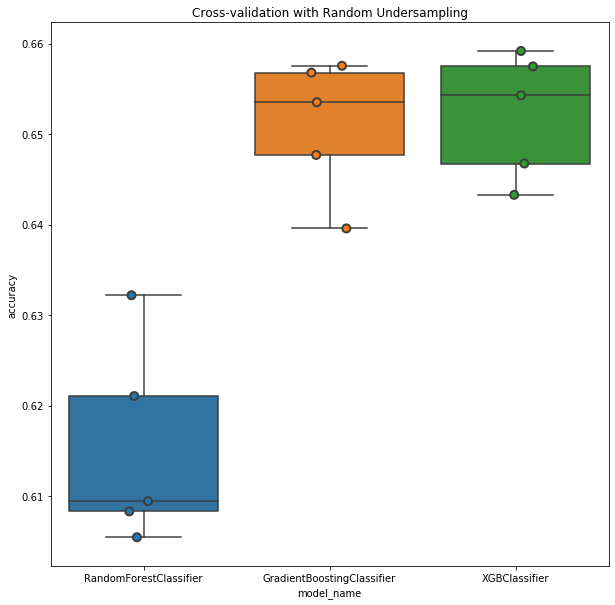

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df,ax=ax)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,ax=ax, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_title('Cross-validation with Random Undersampling')
plt.show()

In [12]:
mean_accs = cv_df.groupby('model_name',as_index=False).accuracy.mean()
mean_accs

,model_name,accuracy
0,GradientBoostingClassifier,0.651022
1,RandomForestClassifier,0.615286
2,XGBClassifier,0.652192


As we can see in terms of the accuracy XGBoost classifier is slightly better that the other models.

Before digging deeper into each model, it is better to create some helper functions to help us create more readable plots and results.

In [13]:
# Helper function to remap common labels to more readable names for plots
def map_labels(labels):

    label_dict = {'diag_3_250':'Third Diagnosis: Diabetes mellitus',
            'diag_3_428': 'Third Diagnosis: Heart failure',
            'diag_3_401':'Third Diagnosis: Essential hypertension',
            'diag_3_403':'Third Diagnosis: Hypertensive renal disease',
            'diag_3_585':'Third Diagnosis: Chronic renal failure',
            'diag_2_250':'Second Diagnosis: Diabetes mellitus',
            'diag_2_403':'Second Diagnosis: Hypertensive renal disease',
            'diag_1_486':'First Diagnosis: Pneumonia',
            'diag_1_786':'First Diagnosis: Dyspnea',
            'diag_1_Others':'First Diagnosis: Others',
            'glimepiride_Steady':'Glimepiride: Steady',
            'diabetesMed_No': 'Diabetes Medication: No',
            'number_emergency':'Number of Emergency Visits',
            'number_diagnoses':'Number of Diagnoses',
            'medical_specialty_Radiologist':'Medical Specialty: Radiologist',
            'admission_source_id_6':'Transferred From Another Healthcare',
            'admission_type_id_6': 'Admission Type: Unknown',
            'insulin_No': 'Insulin: NO',
            'diabetesMed_Yes':'Diabetes Medication: Yes',
            'discharge_disposition_id_1':'Discharged to Home',
            'discharge_disposition_id_2':'Discharged to Another Hospital',
            'discharge_disposition_id_3':'Discharged to Skilled Nursing Facility',
            'discharge_disposition_id_5':'Discharged to Inpatient Care Institute',
            'discharge_disposition_id_22':'Discharged to Another Rehab Facility',
            'discharge_disposition_id_6':'Discharged to Home with Home Health Service',
            'payer_code_UNK': 'Unknown Payer code',
            'number_inpatient':'Number of Inpatient Visits',
            'number_outpatient':'Number of outpatient Visits',
            'num_procedures':'Number of Procedures',
            'num_medications':'Number of Medications', 'age':'Age', 
            'num_lab_procedures':'Number of Lab Procedures',
            'time_in_hospital':'Time in Hospital'}

    return list(labels.replace(label_dict))

In [14]:
# Helper function to print the results
def print_results(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    labels = ['Not readmiited <30 days', 'readmiited <30 days']
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print(classification_report(y_test, y_pred))

In [15]:
# Helper function to print the important features based on 'weight' (counting
# the number of times a feature is used in all generated trees)
def plot_important_features(model, column_names, num_features, plot_title):
    
    feature_importances = model.feature_importances_

    feature_importances = pd.DataFrame(feature_importances,
                                       index = column_names,
                                        columns=['importance']).sort_values('importance',
                                                                            ascending=False)
    ylocs = np.arange(num_features)

    values_to_plot = feature_importances.iloc[:num_features].values.ravel()[::-1]
    feature_labels = map_labels(pd.Series(feature_importances.iloc[:num_features].index))[::-1]

    plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
    plt.barh(ylocs, values_to_plot, align = 'center')
    plt.ylabel('Features')
    plt.xlabel('Importance Score')
    plt.title(plot_title)
    plt.yticks(ylocs, feature_labels)
    plt.show()

Now we can evaluate the models on the test set. To do that we need to run the model on the undersampled version.

In [16]:
# Undersampling and shuffling the training set to see the results on the testset
undersample = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersample.fit_resample(X_train_tf, y_train)
X_train_us, y_train_us = shuffle(X_train_us, y_train_us, random_state=42)

## XGBoost Model Results

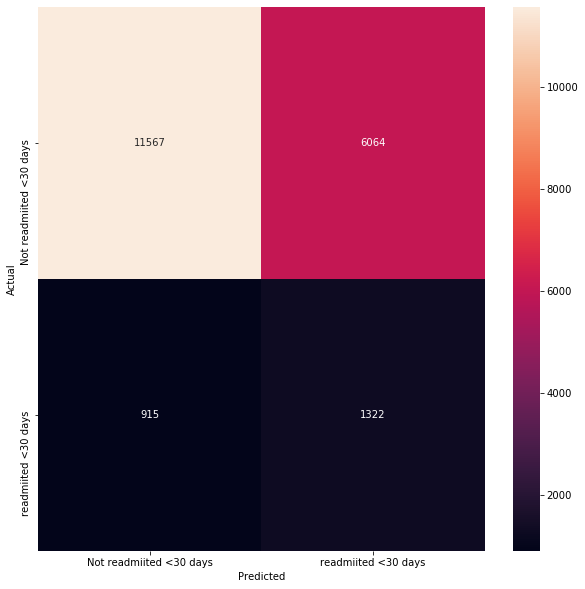

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     17631
           1       0.18      0.59      0.27      2237

    accuracy                           0.65     19868
   macro avg       0.55      0.62      0.52     19868
weighted avg       0.84      0.65      0.71     19868



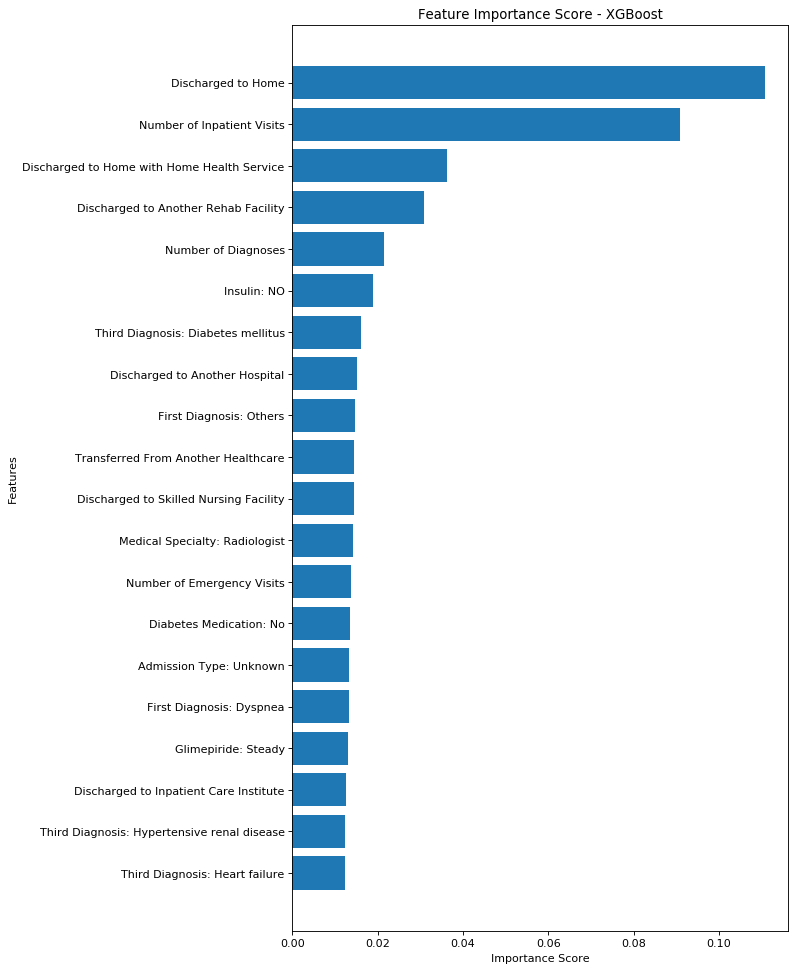

In [17]:
# XGBoost results on the test set
xgb_model = models[2]
xgb_model.fit(X_train_us, y_train_us)
xgb_y_pred = xgb_model.predict(X_test_tf)
print_results(y_test, xgb_y_pred)
plot_important_features(xgb_model, list(all_X_train.columns), 20, 'Feature Importance Score - XGBoost')

In [18]:
roc_auc_score(y_test, xgb_y_pred)

0.6235151987116203

## Gradien Boosting Model Results

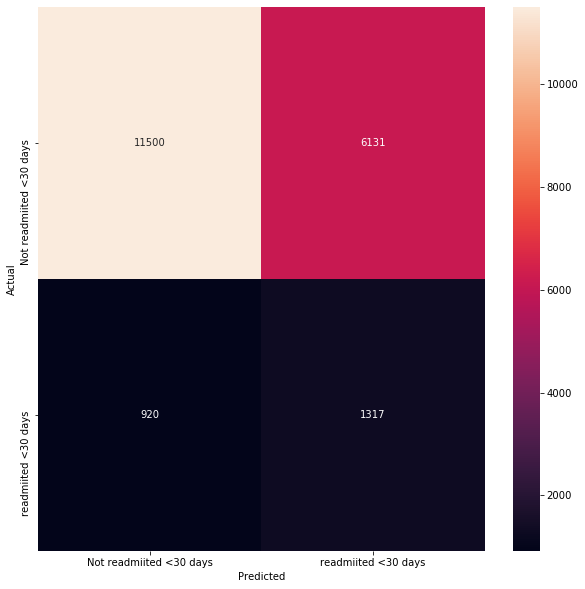

              precision    recall  f1-score   support

           0       0.93      0.65      0.77     17631
           1       0.18      0.59      0.27      2237

    accuracy                           0.65     19868
   macro avg       0.55      0.62      0.52     19868
weighted avg       0.84      0.65      0.71     19868



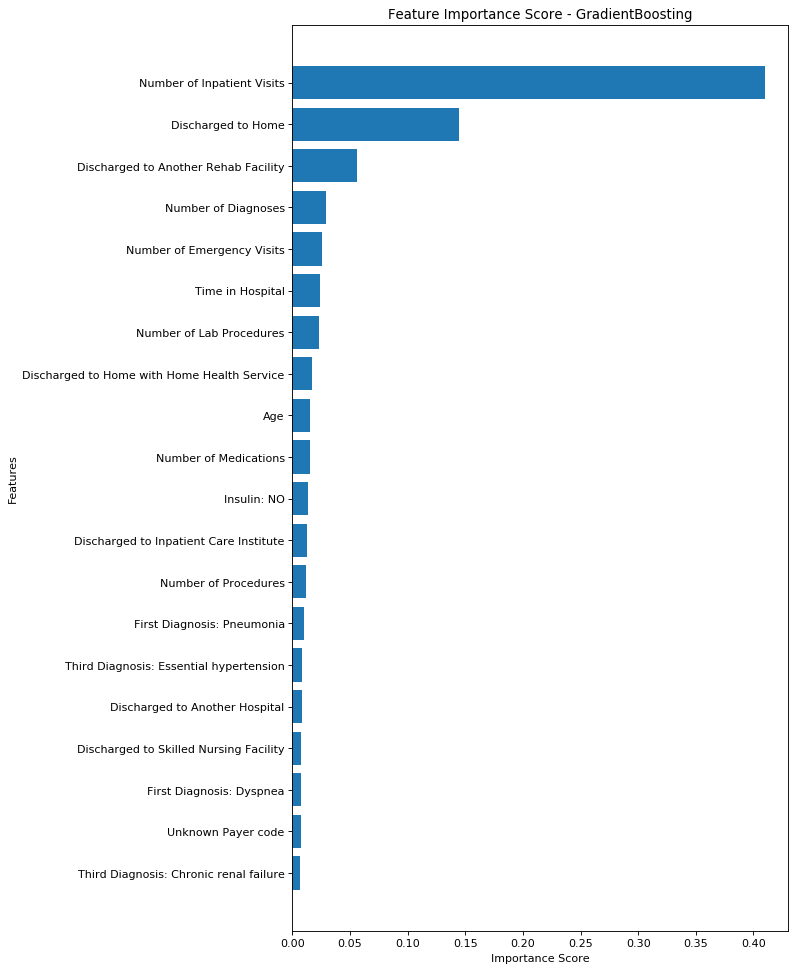

In [19]:
# Gradient Boosting results on the test set
gb_model = models[1]
gb_model.fit(X_train_us, y_train_us)  

gb_y_pred = gb_model.predict(X_test_tf)
print_results(y_test, gb_y_pred)
plot_important_features(gb_model, list(all_X_train.columns), 20, 'Feature Importance Score - GradientBoosting')

In [20]:
roc_auc_score(y_test, gb_y_pred)

0.6204975681498535

## Random Forest Model Results

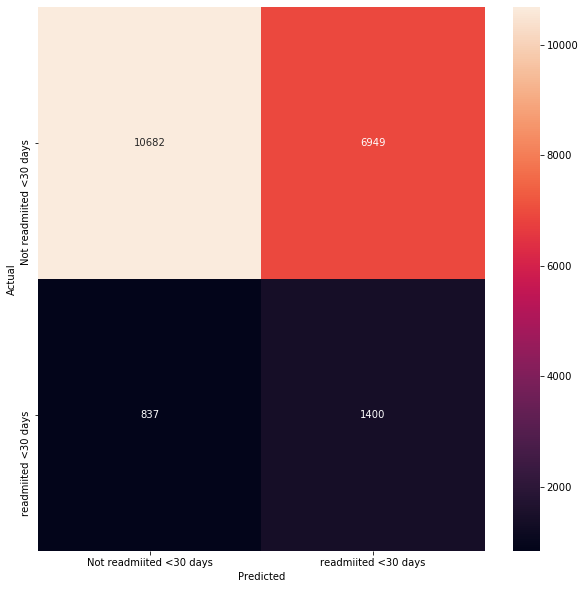

              precision    recall  f1-score   support

           0       0.93      0.61      0.73     17631
           1       0.17      0.63      0.26      2237

    accuracy                           0.61     19868
   macro avg       0.55      0.62      0.50     19868
weighted avg       0.84      0.61      0.68     19868



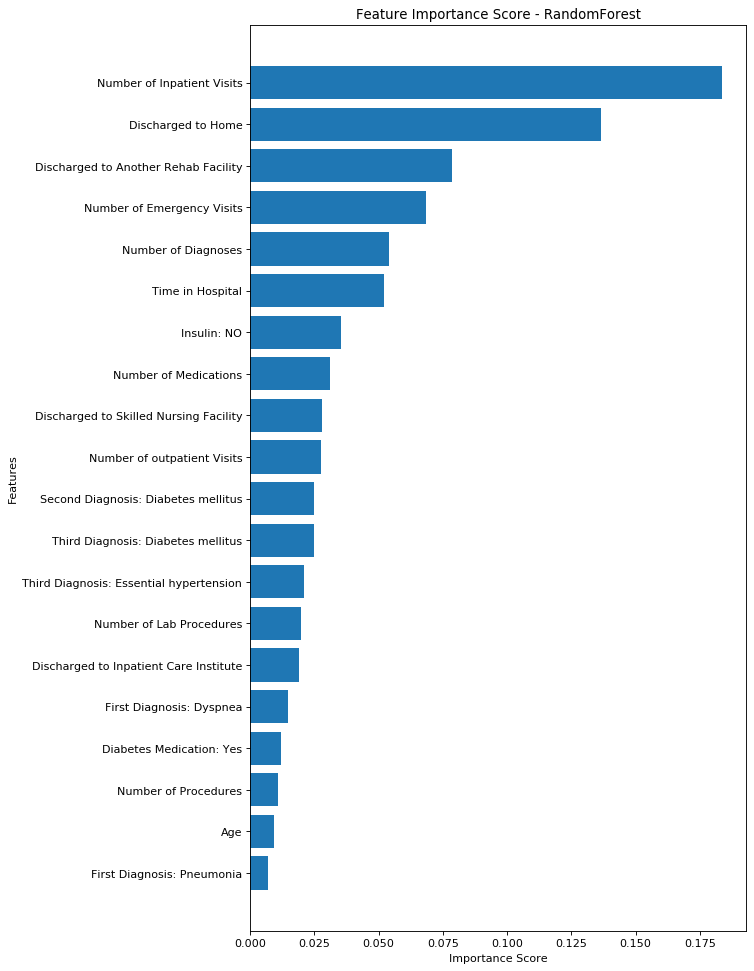

In [21]:
# Random Forest results on the test set
rf_model = models[0]
rf_model.fit(X_train_us, y_train_us)  

rf_y_pred = rf_model.predict(X_test_tf)
print_results(y_test, rf_y_pred)
plot_important_features(rf_model, list(all_X_train.columns), 20, 'Feature Importance Score - RandomForest')

In [22]:
roc_auc_score(y_test, rf_y_pred)

0.615851423155972

We can see that XGBoost and Gradient Boosting model performances are really close to each other and XGBoost AUC is slightly better than other models. Since in this case AUC is more impotant to us than accuracy or recall alone, we decided to choose this model for interpretation and optimizing.

# Hyperparameter Tunning for Top Model

In [23]:
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,10,2)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

params = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}
new_params = {'xgbclassifier__' + key: params[key] for key in params}

auc = make_scorer(roc_auc_score)
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42),shuffle(random_state=42), models[2])
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=2, scoring=auc,
                        return_train_score=True)

In [24]:
grid_imba.fit(X_train_tf, y_train)
grid_imba.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 100}

In [25]:
grid_imba.best_score_

0.6171555953833372

After doing the grid search on different parameters, we see that the best parameters are actually the ones that we trained with initially. Just to double check we print the results for the fine tuned model as well.

In [26]:
best_xgb_model = grid_imba.best_estimator_.named_steps['xgbclassifier']
y_test_predict = best_xgb_model.predict(X_test_tf)

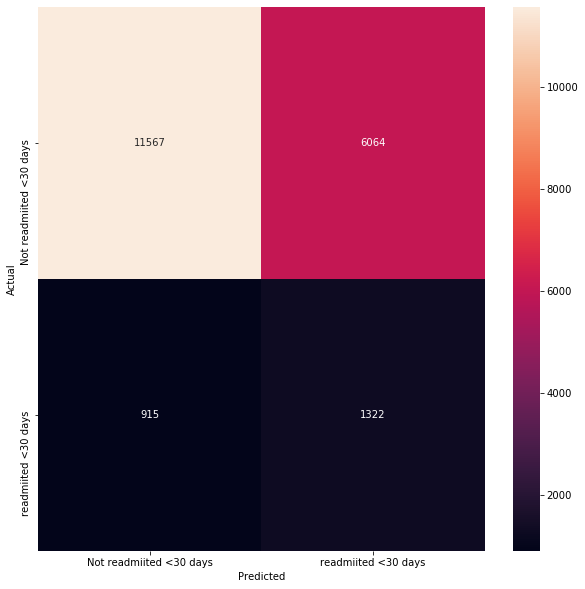

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     17631
           1       0.18      0.59      0.27      2237

    accuracy                           0.65     19868
   macro avg       0.55      0.62      0.52     19868
weighted avg       0.84      0.65      0.71     19868



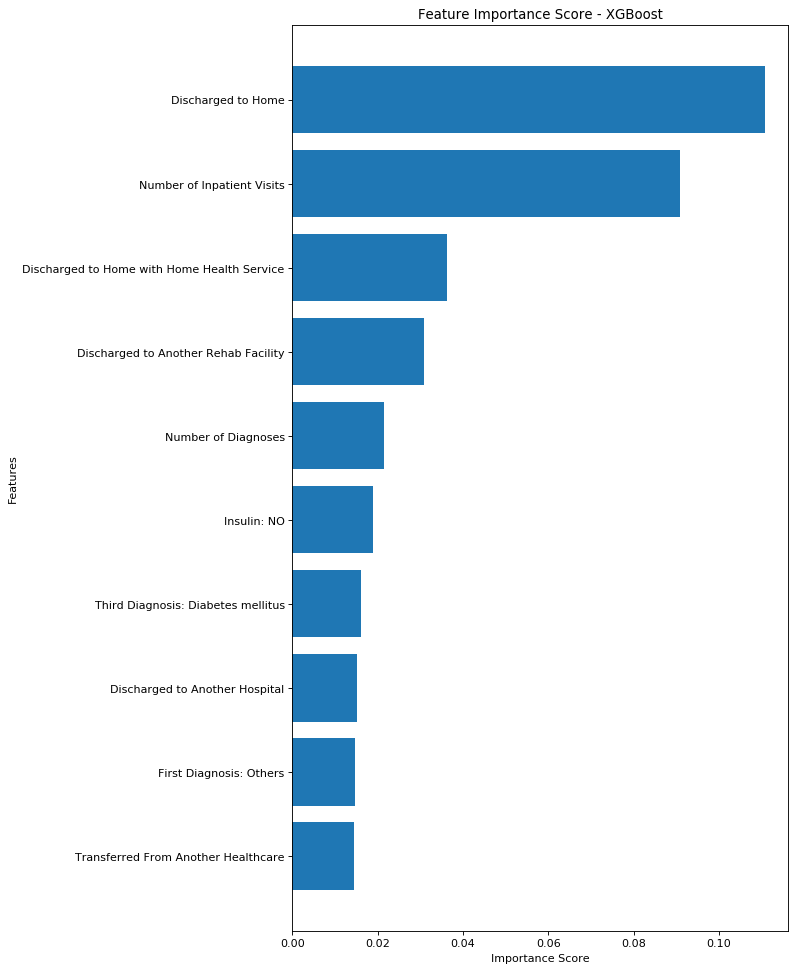

0.6235151987116203

In [27]:
print_results(y_test, y_test_predict)
plot_important_features(best_xgb_model, list(all_X_train.columns), 10, 'Feature Importance Score - XGBoost')
roc_auc_score(y_test, y_test_predict)

The above table shows the top 10 features based on the 'weight' or frequency (counting the number of times a feature is used in all generated trees). This type of analysis does not tell us anything about the direction that each feature effected the result. To do deeper analysis we need to use SHAP values.

# SHAP Values

Feature importance lets us know which features are ostly used among all the decision trees in XGBoost. But it does not let us know whether the feature had a positive or negative effect on being classified as readmitted. One of the methods to see the direction of the effect, is using shap values.
Since we are interested to know what the model has learned from the training set, we run the shap values on the training set.

In [28]:
#Adding back the label of the columns to the transformed for the use of the shap library
X = pd.DataFrame(X_train_us,columns=map_labels(pd.Series(all_X_train.columns)))
X.head()

,Age,Time in Hospital,Number of Diagnoses,Number of Lab Procedures,Number of Procedures,Number of Medications,Number of outpatient Visits,Number of Emergency Visits,Number of Inpatient Visits,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,Admission Type: Unknown,admission_type_id_7,admission_type_id_8,Discharged to Home,discharge_disposition_id_10,discharge_disposition_id_12,discharge_disposition_id_15,discharge_disposition_id_16,discharge_disposition_id_17,discharge_disposition_id_18,Discharged to Another Hospital,Discharged to Another Rehab Facility,discharge_disposition_id_23,discharge_disposition_id_24,discharge_disposition_id_25,discharge_disposition_id_27,discharge_disposition_id_28,Discharged to Skilled Nursing Facility,discharge_disposition_id_4,Discharged to Inpatient Care Institute,Discharged to Home with Home Health Service,discharge_disposition_id_7,discharge_disposition_id_8,discharge_disposition_id_9,admission_source_id_1,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_2,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,Transferred From Another Healthcare,admission_source_id_7,admission_source_id_8,admission_source_id_9,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,Unknown Payer code,payer_code_WC,medical_specialty_Cardiology,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Others,Medical Specialty: Radiologist,medical_specialty_Surgery-General,medical_specialty_UNK,diag_1_410,diag_1_414,diag_1_427,diag_1_428,First Diagnosis: Pneumonia,diag_1_491,diag_1_682,diag_1_715,diag_1_780,First Diagnosis: Dyspnea,First Diagnosis: Others,Second Diagnosis: Diabetes mellitus,diag_2_276,diag_2_401,Second Diagnosis: Hypertensive renal disease,diag_2_411,diag_2_414,diag_2_427,diag_2_428,diag_2_496,diag_2_599,diag_2_Others,Third Diagnosis: Diabetes mellitus,diag_3_272,diag_3_276,Third Diagnosis: Essential hypertension,Third Diagnosis: Hypertensive renal disease,diag_3_414,diag_3_427,Third Diagnosis: Heart failure,diag_3_496,Third Diagnosis: Chronic renal failure,diag_3_Others,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_Down,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_Down,glimepiride_No,Glimepiride: Steady,glimepiride_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,tolazamide_No,tolazamide_Steady,tolazamide_Up,insulin_Down,Insulin: NO,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,change_Ch,change_No,Diabetes Medication: No,Diabetes Medication: Yes
0,-0.049644,1.225801,-1.237921,0.108118,2.740697,2.604859,-0.293863,-0.205466,1.090054,-0.480999,-0.079969,-1.723146,-0.144661,8.114146,0.923891,-0.923891,-1.055547,-0.474085,2.081752,-0.010642,-0.221258,-0.2

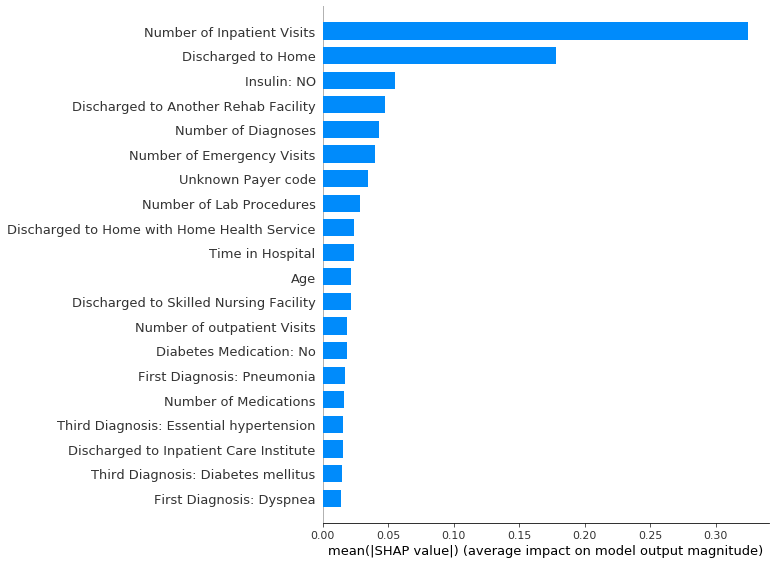

In [29]:
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar",title="XGBoost top features based on SHAP values")

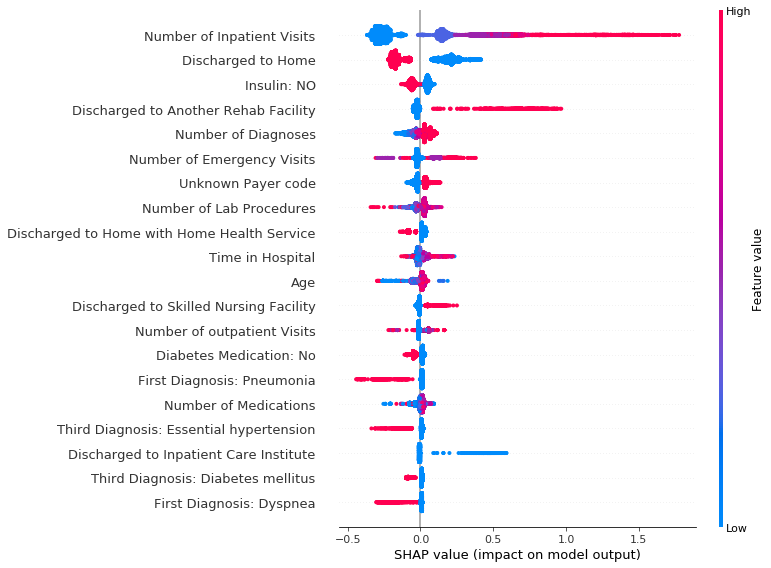

In [30]:
shap.summary_plot(shap_values, X, title="XGBoost top features based on SHAP values")

In the above SHAP plot x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).<br>
As we can see from the graph above, some of the features such as the number of inpatient visits in the year preceding the encounter or being discharged to another rehab facility have a positive affect on being readmitted within 30 days. In other words if the patient has had a higher number of inpatient visits or if he/she was transferred to another rehab facility, there is higher probability that they will get readmitted within 30 days. Features such as being discharged to home, no insulin and no diabetes medication have a negative effect on the prediction, meaning if the patient is discharged to home or if he/she is not prescribed with insulin (or any diabetes medication), there is higher chance that they will not get readmitted within 30 days.<br>
Also we can see that the higher the number of diagnoses, the higher the chance of being readmitted within 30 days (based on our model). Furtermore, older patients and patients that spent a longer time in the hospital are more likely to be readmitted within 30 days.<BR>
Two other interesting facts are that if the patient is diagnosed with pnemunia or dyspnea (a breathing problem) as the first diagnosis or essential hyper tension or diabetes mellitus as the third diagnosis, there will be a lower probability of getting readmitted within 30 days.


To dig deeper into the effect of some of the top features, let's plot the dependence plots for the top features). Note that unlike traditional partial dependence plots (which show the average model output when changing a feature’s value) these SHAP dependence plots show interaction effects.

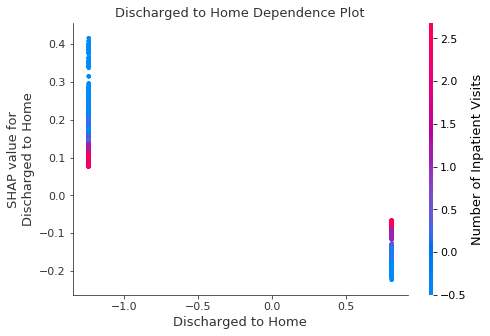

In [31]:
shap.dependence_plot('Discharged to Home', shap_values, X,title='Discharged to Home Dependence Plot')

The y-axis is how much being discharged to home changes the log odds of getting readmitted within 30 days. The x-axis shows the standardized values for being discharged to home.

Here, again we can see that being discharged to home results in negative SHAP values (negative effect on getting classifed as readmitted within 30 days), while not being discharged to home has higher positive shap values (there will be a higher chance of readmission). Also here we can see the interaction of the number of inpatient visits with being discharged to home. It is also interesting to see that if the patient was discharged to home, higher number of inpatients visits resulted in higher shap values (in other words contributes to being classified as readmitted), while amonge the patients that were not discharged to home, number of inpatient visits had an inverse effect. Ino ther words, those who had lower number of inpatients visits had higher shap values and contributed more to being readmitted compared to those who had higher number of inpatients visits.

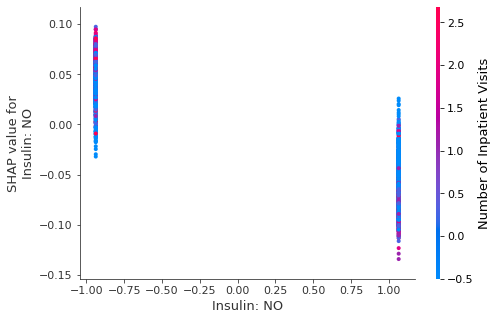

In [32]:
shap.dependence_plot('Insulin: NO', shap_values, X)

And here we can see that patients that had no insulin prescribed for them, had lower shap values (had lower chance of getting readmitted), while those who had insulin prescribed for them were more likely to get readmitted within 30 days (most probably because their condition required more health care compared to those that did not take insulin). There is no specific interaction of number of inpatient visits with having or not having insulin prescribed.

In [33]:
y_train_us

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

## Force Plot for a Positive Case

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


This is a case where the patient was readmitted within 30 days. We can see the top features that contributed to increasing the probability of being readmitted were Number of Inpatient visits and not being discharged to home and having hypertensive renal disease as the second diagnosis. While no insulin being prescribed and low number of diagnosis lowered the probability of getting classified as readmitted.

## Force Plot for a Negative Case

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[-2,:], X.iloc[-2,:])

This is a case where the patient was not readmitted within 30 days. We can see the top features that contributed to increasing the probability of being readmitted were discharged to another hospital. While low number of inpatient visits and orthopedics medical specialty lowered the probability to a number very close to 0.

# Conclusion
The results of modelling notes that the most significant factors which predict re-admission are a combination of both the patient’s patterns of behaviour (e.g.number of emergency visits and number of inpatient visits)and  particular  outcomes  of  their  visit  (e.g.  discharged  tohome/another rehab/nursing facility) and the condition of their wellness which is kind of indicated by whether they were prescribed insulin or any diabetes medication or not.